# **Super-Resolution with Deep Image Prior**

# Load T4 GPU in Colab

1. Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab

2. Load GitHub resource

In [2]:
!git clone https://github.com/shayaan-ahm3d/AVAI-week2
!mv AVAI-week2/* ./

Cloning into 'AVAI-week2'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 32 (delta 4), reused 30 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (32/32), 3.79 MiB | 8.43 MiB/s, done.
Resolving deltas: 100% (4/4), done.


# Parameters of super resolution

2.PLOT shows whether you want to see the image.

In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os

import numpy as np
from models import *

import torch
import torch.optim

from skimage.metrics import peak_signal_noise_ratio
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True

use_gpu = False

if use_gpu:
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.float32

imsize =-1
PLOT = True

# Load the high resolution image and low resolution image

In [4]:
from dataset import Div2kDataset, Mode
from pathlib import Path

from utils.common_utils import pil_to_np, np_to_pil, np_to_torch, torch_to_np
from utils.sr_utils import crop_image

low_res_path = Path("dataset/DIV2K_train_LR_x8")
high_res_path = Path("dataset/DIV2K_train_HR")
dataset = Div2kDataset(low_res_path, high_res_path, Mode.TRAIN)

low = crop_image(dataset[0][0])
high = crop_image(dataset[0][1])

low_np = pil_to_np(low)
high_np = pil_to_np(high)

ModuleNotFoundError: No module named 'dataset'

# Set up the parameters for training

Main parameters

1. **num_iter** controls the number of iterations for training

2. **LR** controls the learning rate

3. Two types of **optimizer** exists here. (1) **adam** (2)
 **LBFGS**

In function **get_net**, there exists five types of Neural Network (1) **ResNet** (2) **skip** (3) **texture_nets** (4) **UNet** (5) **identity**


Variable **mse** controls the type of loss here.

In [7]:
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

#training parameters
reg_noise_std = 1./30.
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99

num_iter = 500
input_depth = 3
figsize = 4

#Network structure
net = get_net(input_depth, 'skip', pad,
              skip_n33d=128,
              skip_n33u=128,
              skip_n11=4,
              num_scales=5,
              upsample_mode='bilinear').type(dtype)

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()])
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

low_torch = np_to_torch(low_np).type(dtype)
high_torch = np_to_torch(high_np).type(dtype)

Number of params: 2184307


**Architecture of the Network of skip**

In [8]:
import torch
import torch.nn as nn
from models.common import *

def skip(
        num_input_channels=2, num_output_channels=3,
        num_channels_down=[16, 32, 64, 128, 128], num_channels_up=[16, 32, 64, 128, 128], num_channels_skip=[4, 4, 4, 4, 4],
        filter_size_down=3, filter_size_up=3, filter_skip_size=1,
        need_sigmoid=True, need_bias=True,
        pad='zero', upsample_mode='nearest', downsample_mode='stride', act_fun='LeakyReLU',
        need1x1_up=True):
    """Assembles encoder-decoder with skip connections.

    Arguments:
        act_fun: Either string 'LeakyReLU|Swish|ELU|none' or module (e.g. nn.ReLU)
        pad (string): zero|reflection (default: 'zero')
        upsample_mode (string): 'nearest|bilinear' (default: 'nearest')
        downsample_mode (string): 'stride|avg|max|lanczos2' (default: 'stride')

    """
    assert len(num_channels_down) == len(num_channels_up) == len(num_channels_skip)

    n_scales = len(num_channels_down)

    if not (isinstance(upsample_mode, list) or isinstance(upsample_mode, tuple)) :
        upsample_mode   = [upsample_mode]*n_scales

    if not (isinstance(downsample_mode, list)or isinstance(downsample_mode, tuple)):
        downsample_mode   = [downsample_mode]*n_scales

    if not (isinstance(filter_size_down, list) or isinstance(filter_size_down, tuple)) :
        filter_size_down   = [filter_size_down]*n_scales

    if not (isinstance(filter_size_up, list) or isinstance(filter_size_up, tuple)) :
        filter_size_up   = [filter_size_up]*n_scales

    last_scale = n_scales - 1

    cur_depth = None

    model = nn.Sequential()
    model_tmp = model

    input_depth = num_input_channels
    for i in range(len(num_channels_down)):

        deeper = nn.Sequential()
        skip = nn.Sequential()

        if num_channels_skip[i] != 0:
            model_tmp.add(Concat(1, skip, deeper))
        else:
            model_tmp.add(deeper)

        model_tmp.add(bn(num_channels_skip[i] + (num_channels_up[i + 1] if i < last_scale else num_channels_down[i])))

        if num_channels_skip[i] != 0:
            skip.add(conv(input_depth, num_channels_skip[i], filter_skip_size, bias=need_bias, pad=pad))
            skip.add(bn(num_channels_skip[i]))
            skip.add(act(act_fun))

        # skip.add(Concat(2, GenNoise(nums_noise[i]), skip_part))

        deeper.add(conv(input_depth, num_channels_down[i], filter_size_down[i], 2, bias=need_bias, pad=pad, downsample_mode=downsample_mode[i]))
        deeper.add(bn(num_channels_down[i]))
        deeper.add(act(act_fun))

        deeper.add(conv(num_channels_down[i], num_channels_down[i], filter_size_down[i], bias=need_bias, pad=pad))
        deeper.add(bn(num_channels_down[i]))
        deeper.add(act(act_fun))

        deeper_main = nn.Sequential()

        if i == len(num_channels_down) - 1:
            # The deepest
            k = num_channels_down[i]
        else:
            deeper.add(deeper_main)
            k = num_channels_up[i + 1]

        deeper.add(nn.Upsample(scale_factor=2, mode=upsample_mode[i]))

        model_tmp.add(conv(num_channels_skip[i] + k, num_channels_up[i], filter_size_up[i], 1, bias=need_bias, pad=pad))
        model_tmp.add(bn(num_channels_up[i]))
        model_tmp.add(act(act_fun))


        if need1x1_up:
            model_tmp.add(conv(num_channels_up[i], num_channels_up[i], 1, bias=need_bias, pad=pad))
            model_tmp.add(bn(num_channels_up[i]))
            model_tmp.add(act(act_fun))

        input_depth = num_channels_down[i]
        model_tmp = deeper_main

    model.add(conv(num_channels_up[0], num_output_channels, 1, bias=need_bias, pad=pad))
    if need_sigmoid:
        model.add(nn.Sigmoid())

    return model

Starting optimization with ADAM
Iteration:  0  Loss:  0.0012062167515978217  PSRN_gt:  29.18574627559732  PSNR_gt_sm:  15.310292225493608


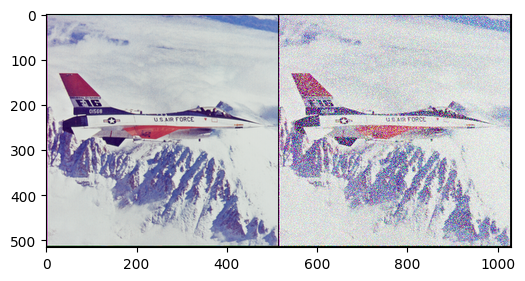

Iteration:  10  Loss:  0.0035076397471129894  PSRN_gt:  24.54985053477328  PSNR_gt_sm:  16.07368950392137
Iteration:  20  Loss:  0.002317591803148389  PSRN_gt:  26.349630551322353  PSNR_gt_sm:  16.893584175293764
Iteration:  30  Loss:  0.0019421614706516266  PSRN_gt:  27.117146804588348  PSNR_gt_sm:  17.68414608777507
Iteration:  40  Loss:  0.0017486171564087272  PSRN_gt:  27.573052647335302  PSNR_gt_sm:  18.45934084511143
Iteration:  50  Loss:  0.0015701595693826675  PSRN_gt:  28.04056222823776  PSNR_gt_sm:  19.220690318350393
Iteration:  60  Loss:  0.0014379819622263312  PSRN_gt:  28.42246549383936  PSNR_gt_sm:  19.962367639933273
Iteration:  70  Loss:  0.001320995157584548  PSRN_gt:  28.790987819364243  PSNR_gt_sm:  20.68863662698048
Iteration:  80  Loss:  0.001228266628459096  PSRN_gt:  29.107074026340204  PSNR_gt_sm:  21.400996766503063
Iteration:  90  Loss:  0.0011417027562856674  PSRN_gt:  29.424469332481692  PSNR_gt_sm:  22.100641534737537
Iteration:  100  Loss:  0.001145809306

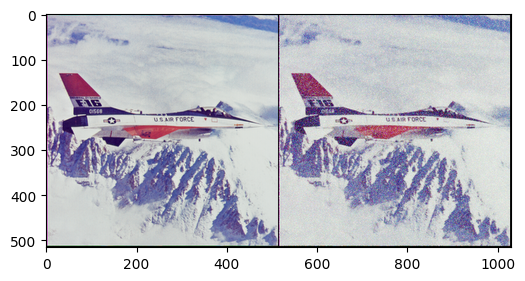

Iteration:  110  Loss:  0.0011199894361197948  PSRN_gt:  29.507860825800527  PSNR_gt_sm:  23.45085726052062
Iteration:  120  Loss:  0.0010612790938466787  PSRN_gt:  29.741704180880205  PSNR_gt_sm:  24.093509775691576
Iteration:  130  Loss:  0.0009763058042153716  PSRN_gt:  30.104141381562112  PSNR_gt_sm:  24.716164864004565
Iteration:  140  Loss:  0.0009212875738739967  PSRN_gt:  30.356048187290092  PSNR_gt_sm:  25.32061716238488
Iteration:  150  Loss:  0.0008938168175518513  PSRN_gt:  30.487514695631944  PSNR_gt_sm:  25.90438287433362
Iteration:  160  Loss:  0.0008558417903259397  PSRN_gt:  30.676065224877064  PSNR_gt_sm:  26.4697151878794
Iteration:  170  Loss:  0.0011424846015870571  PSRN_gt:  29.42149668758121  PSNR_gt_sm:  27.008930951224812
Iteration:  180  Loss:  0.000980885699391365  PSRN_gt:  30.083815748371585  PSNR_gt_sm:  27.460489944075576
Iteration:  190  Loss:  0.0008574651437811553  PSRN_gt:  30.667835542192904  PSNR_gt_sm:  27.898327600319426
Iteration:  200  Loss:  0.

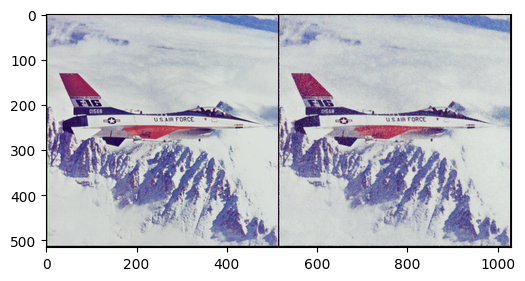

Iteration:  210  Loss:  0.0007246562163345516  PSRN_gt:  31.398680204233717  PSNR_gt_sm:  28.770585378803943
Iteration:  220  Loss:  0.0006863692542538047  PSRN_gt:  31.63442213763956  PSNR_gt_sm:  29.18676922509124
Iteration:  230  Loss:  0.0006893526297062635  PSRN_gt:  31.615585697352312  PSNR_gt_sm:  29.577398999832205
Iteration:  240  Loss:  0.0006452540983445942  PSRN_gt:  31.90269242871624  PSNR_gt_sm:  29.943632478294
Iteration:  250  Loss:  0.0006363146821968257  PSRN_gt:  31.963280542520558  PSNR_gt_sm:  30.28750034800869
Iteration:  260  Loss:  0.0006179000483825803  PSRN_gt:  32.09081756718002  PSNR_gt_sm:  30.607423858582056
Iteration:  270  Loss:  0.0005940134869888425  PSRN_gt:  32.2620372237818  PSNR_gt_sm:  30.905947443643722
Iteration:  280  Loss:  0.0007473345613107085  PSRN_gt:  31.264849894331938  PSNR_gt_sm:  31.174553095426777
Iteration:  290  Loss:  0.0008598947897553444  PSRN_gt:  30.655546871870634  PSNR_gt_sm:  31.329266064058675
Iteration:  300  Loss:  0.000

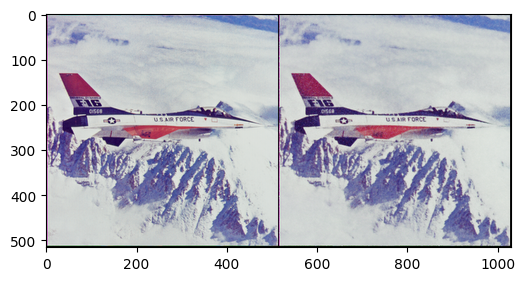

Iteration:  310  Loss:  0.0006299460656009614  PSRN_gt:  32.00696646895785  PSNR_gt_sm:  31.659063165855624
Iteration:  320  Loss:  0.0005936031229794025  PSRN_gt:  32.26503832882892  PSNR_gt_sm:  31.834077268578017
Iteration:  330  Loss:  0.0005706498632207513  PSRN_gt:  32.43630316156506  PSNR_gt_sm:  32.00596557178254
Iteration:  340  Loss:  0.0005524916923604906  PSRN_gt:  32.5767429103323  PSNR_gt_sm:  32.17205326688595
Iteration:  350  Loss:  0.0005436678766272962  PSRN_gt:  32.64666337903887  PSNR_gt_sm:  32.32927603112485
Iteration:  360  Loss:  0.0005267394008114934  PSRN_gt:  32.78404228207796  PSNR_gt_sm:  32.480567392831006
Iteration:  370  Loss:  0.0005439257947728038  PSRN_gt:  32.644603454763214  PSNR_gt_sm:  32.61975967497099
Iteration:  380  Loss:  0.0005418552318587899  PSRN_gt:  32.661167577348216  PSNR_gt_sm:  32.74960411714764
Iteration:  390  Loss:  0.0005190803203731775  PSRN_gt:  32.84765424855835  PSNR_gt_sm:  32.87197414217559
Iteration:  400  Loss:  0.0005003

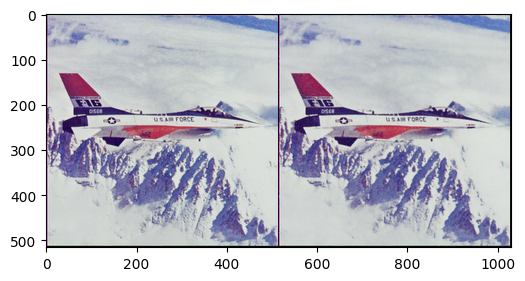

Iteration:  410  Loss:  0.00048776084440760314  PSRN_gt:  33.11793069817498  PSNR_gt_sm:  33.101832616470695
Iteration:  420  Loss:  0.00047563103726133704  PSRN_gt:  33.227298156045705  PSNR_gt_sm:  33.21114270477167
Iteration:  430  Loss:  0.0004773999098688364  PSRN_gt:  33.211176571325424  PSNR_gt_sm:  33.31537549644005
Iteration:  440  Loss:  0.0004968190914951265  PSRN_gt:  33.0380172494974  PSNR_gt_sm:  33.414991242498544
Iteration:  450  Loss:  0.00047578458907082677  PSRN_gt:  33.22589641295551  PSNR_gt_sm:  33.506802197654565
Iteration:  460  Loss:  0.00045724594383500516  PSRN_gt:  33.398501256934104  PSNR_gt_sm:  33.59362827829217
Iteration:  470  Loss:  0.0004826773365493864  PSRN_gt:  33.163430871188986  PSNR_gt_sm:  33.678092382606295
Iteration:  480  Loss:  0.0004488937556743622  PSRN_gt:  33.478564361790156  PSNR_gt_sm:  33.75725977355947
Iteration:  490  Loss:  0.00044448309927247465  PSRN_gt:  33.52144758933248  PSNR_gt_sm:  33.83362456380429


In [ ]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
#smoothing image
out_avg = net_input_saved

#without smoothing
#out_avg = None

last_net = None
psrn_noisy_last = 0

i = 0
def closure():
    global i, out_avg, psrn_noisy_last, last_net, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = net(net_input)

    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)

    #total_loss = mse(out, img_noisy_torch)
    total_loss = mse(out, high_torch)
    total_loss.backward()

    #evaluation with psrn
    psrn_noisy = peak_signal_noise_ratio(low_np, out.detach().cpu().numpy()[0])
    psrn_gt    = peak_signal_noise_ratio(high_np, out.detach().cpu().numpy()[0])
    psrn_gt_sm = peak_signal_noise_ratio(high_np, out_avg.detach().cpu().numpy()[0])

    if  PLOT and i % 10 == 0:
         print ('Iteration: ', i, ' Loss: ', total_loss.item(), ' PSRN_gt: ', psrn_gt, ' PSNR_gt_sm: ', psrn_gt_sm)
    #print ('Iteration %05d    Loss %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        #out_np = torch_to_np(out)
        plot_image_grid([np.clip(low_np, 0, 1),
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=2)



    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5:
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy

    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

# Show the result

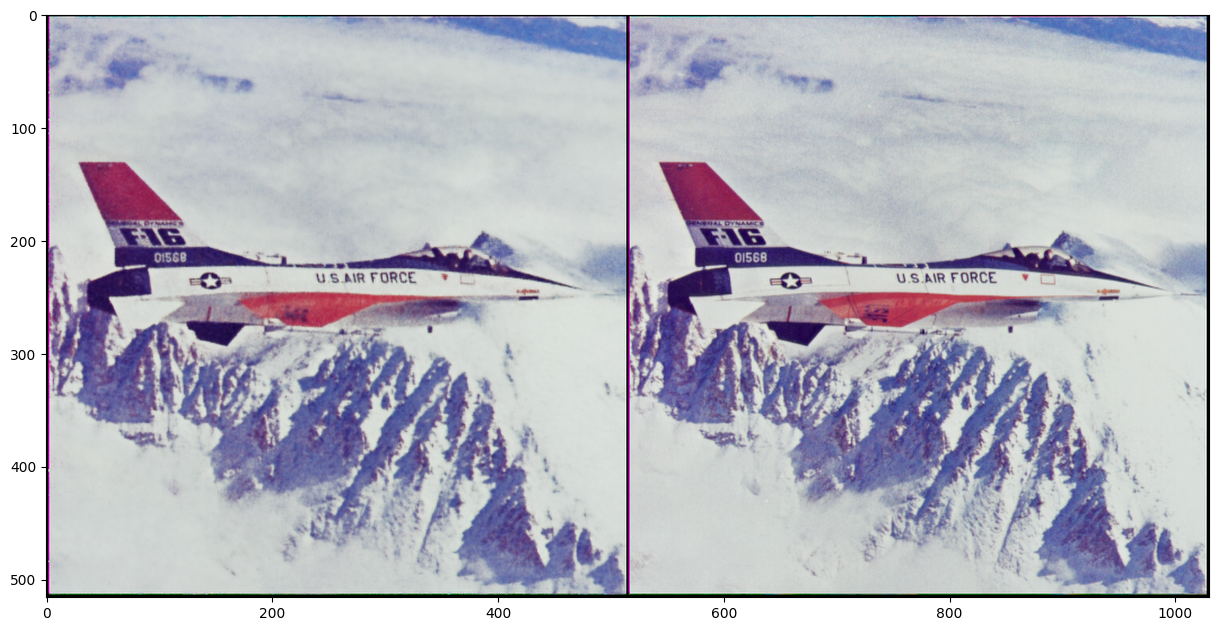

In [14]:
out_np = torch_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);